In [1]:
# !pip install torch_geometric

### Simple Graph Neural Network application for understanding purpose, not for accuracy

In [4]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

In [5]:
DATA_PATH = "/kaggle/input/movielens-100k-dataset/ml-100k/u.data"

ratings = pd.read_csv(
    DATA_PATH,
    sep="\t",
    names=["userId", "movieId", "rating", "timestamp"]
)

ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()

user_id_map = {id: i for i, id in enumerate(ratings['userId'].unique())}
movie_id_map = {id: i + num_users for i, id in enumerate(ratings['movieId'].unique())}

ratings['user_node'] = ratings['userId'].map(user_id_map)
ratings['movie_node'] = ratings['movieId'].map(movie_id_map)

num_nodes = num_users + num_movies

In [8]:
import numpy as np

edge_index = np.vstack([
    ratings['user_node'].values,
    ratings['movie_node'].values
])

edge_index = torch.from_numpy(edge_index).long()

# Make graph undirected
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

In [9]:
print(edge_index.shape)

torch.Size([2, 200000])


In [10]:
embedding_dim = 64
x = torch.nn.Embedding(num_nodes, embedding_dim).weight


In [11]:
data = Data(x=x, edge_index=edge_index)

In [12]:
class GNNRecommender(torch.nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.conv1 = GCNConv(hidden_dim, 64)
        self.conv2 = GCNConv(64, 32)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [13]:
def predict(user_emb, movie_emb):
    return (user_emb * movie_emb).sum(dim=1)

In [14]:
pos_user = torch.tensor(ratings['user_node'].values)
pos_movie = torch.tensor(ratings['movie_node'].values)

num_pos = len(pos_user)

neg_user = torch.randint(0, num_users, (num_pos,))
neg_movie = torch.randint(num_users, num_nodes, (num_pos,))

In [15]:
model = GNNRecommender()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [18]:
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()

    embeddings = model(data.x, data.edge_index)

    pos_scores = predict(embeddings[pos_user], embeddings[pos_movie])
    neg_scores = predict(embeddings[neg_user], embeddings[neg_movie])

    labels = torch.cat([
        torch.ones_like(pos_scores),
        torch.zeros_like(neg_scores)
    ])

    scores = torch.cat([pos_scores, neg_scores])

    loss = F.binary_cross_entropy_with_logits(scores, labels)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 10, Loss: 0.4309
Epoch 20, Loss: 0.4281
Epoch 30, Loss: 0.4248
Epoch 40, Loss: 0.4217
Epoch 50, Loss: 0.4187
Epoch 60, Loss: 0.4160
Epoch 70, Loss: 0.4136
Epoch 80, Loss: 0.4137
Epoch 90, Loss: 0.4103
Epoch 100, Loss: 0.4083
Epoch 110, Loss: 0.4067
Epoch 120, Loss: 0.4048
Epoch 130, Loss: 0.4031
Epoch 140, Loss: 0.4023
Epoch 150, Loss: 0.4010
Epoch 160, Loss: 0.3993
Epoch 170, Loss: 0.3975
Epoch 180, Loss: 0.3970
Epoch 190, Loss: 0.3956
Epoch 200, Loss: 0.3978


In [19]:
def recommend_movies(user_id, top_k=5):
    model.eval()
    embeddings = model(data.x, data.edge_index)

    user_node = user_id_map[user_id]
    scores = []

    for movie_id in ratings['movieId'].unique():
        movie_node = movie_id_map[movie_id]
        score = torch.dot(embeddings[user_node], embeddings[movie_node])
        scores.append((movie_id, score.item()))

    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:top_k]

In [20]:
recommend_movies(user_id=196)

[(np.int64(286), 0.7806031107902527),
 (np.int64(300), 0.7302932739257812),
 (np.int64(100), 0.5481033325195312),
 (np.int64(258), 0.5462428331375122),
 (np.int64(50), 0.5258164405822754)]

In [21]:
ITEM_PATH = "/kaggle/input/movielens-100k-dataset/ml-100k/u.item"

movies = pd.read_csv(
    ITEM_PATH,
    sep="|",
    encoding="latin-1",
    header=None
)

movies = movies[[0, 1]]
movies.columns = ["movieId", "title"]

movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [22]:
movie_id_to_title = dict(zip(movies.movieId, movies.title))

In [23]:
def recommend_movies(user_id, top_k=5):
    model.eval()
    embeddings = model(data.x, data.edge_index)

    user_node = user_id_map[user_id]
    scores = []

    for movie_id in ratings['movieId'].unique():
        movie_node = movie_id_map[movie_id]
        score = torch.dot(embeddings[user_node], embeddings[movie_node])
        scores.append((movie_id, score.item()))

    scores.sort(key=lambda x: x[1], reverse=True)

    recommendations = []
    for movie_id, score in scores[:top_k]:
        title = movie_id_to_title.get(movie_id, "Unknown")
        recommendations.append((title, score))

    return recommendations

In [24]:
recommend_movies(user_id=196)

[('English Patient, The (1996)', 0.7806031107902527),
 ('Air Force One (1997)', 0.7302932739257812),
 ('Fargo (1996)', 0.5481033325195312),
 ('Contact (1997)', 0.5462428331375122),
 ('Star Wars (1977)', 0.5258164405822754)]

In [25]:
import networkx as nx
import matplotlib.pyplot as plt

In [32]:
# pick one user
sample_user_id = 186
sample_user_node = user_id_map[sample_user_id]

# movies this user interacted with
user_movies = ratings[ratings['userId'] == sample_user_id]['movieId'].head(10)

sample_movie_nodes = [movie_id_map[mid] for mid in user_movies]

# nodes to visualize
nodes_to_plot = [sample_user_node] + sample_movie_nodes

In [33]:
G = nx.Graph()

# add nodes
for node in nodes_to_plot:
    G.add_node(node)

# add edges
for _, row in ratings.iterrows():
    if row['user_node'] in nodes_to_plot and row['movie_node'] in nodes_to_plot:
        G.add_edge(row['user_node'], row['movie_node'])

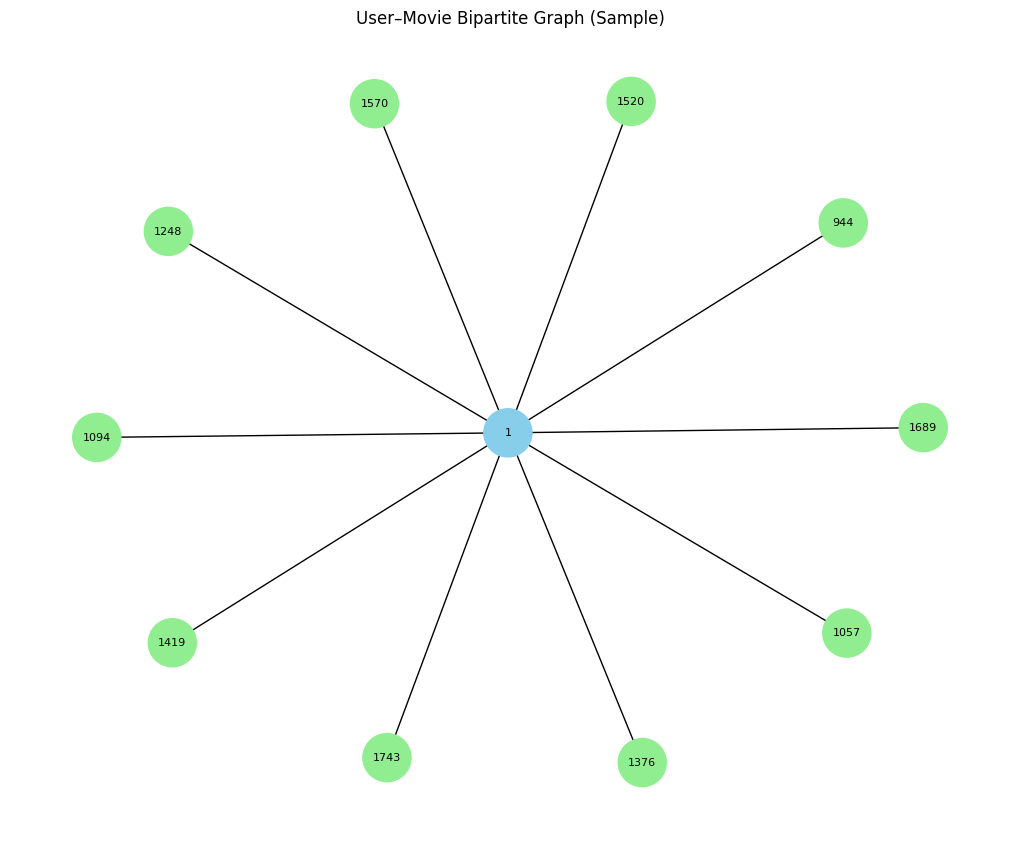

In [34]:
plt.figure(figsize=(10, 8))

pos = nx.spring_layout(G, seed=42)

node_colors = []
for node in G.nodes():
    if node < num_users:
        node_colors.append("skyblue")   # user
    else:
        node_colors.append("lightgreen")  # movie

nx.draw(
    G,
    pos,
    with_labels=True,
    node_color=node_colors,
    node_size=1200,
    font_size=8
)

plt.title("User–Movie Bipartite Graph (Sample)")
plt.show()

In [37]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [35]:
model.eval()
embeddings = model(data.x, data.edge_index).detach().cpu().numpy()

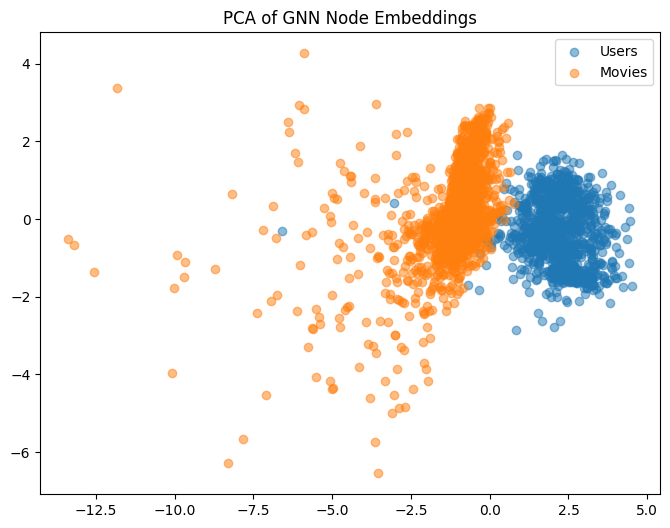

In [38]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(
    emb_2d[:num_users, 0],
    emb_2d[:num_users, 1],
    alpha=0.5,
    label="Users"
)
plt.scatter(
    emb_2d[num_users:, 0],
    emb_2d[num_users:, 1],
    alpha=0.5,
    label="Movies"
)
plt.legend()
plt.title("PCA of GNN Node Embeddings")
plt.show()

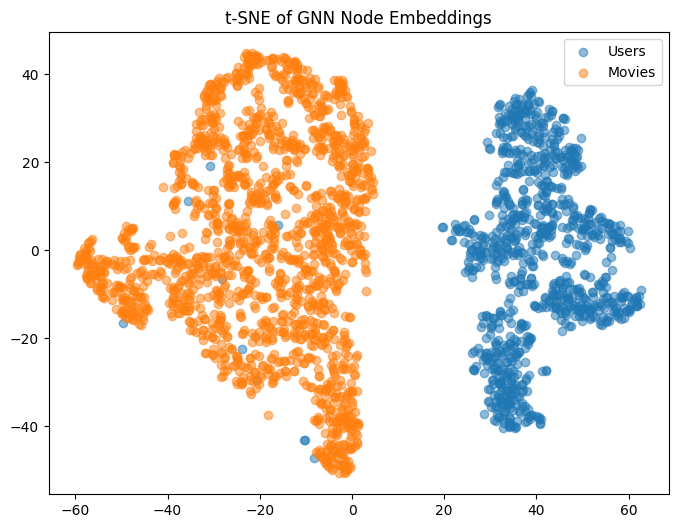

In [39]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(
    emb_tsne[:num_users, 0],
    emb_tsne[:num_users, 1],
    alpha=0.5,
    label="Users"
)
plt.scatter(
    emb_tsne[num_users:, 0],
    emb_tsne[num_users:, 1],
    alpha=0.5,
    label="Movies"
)
plt.legend()
plt.title("t-SNE of GNN Node Embeddings")
plt.show()

#  GOAL (What we’ll build)
# 1️⃣ Graph with movie titles as labels
# 2️⃣ Embedding visualization (PCA / t-SNE)
# 3️⃣ Dashed edges for predicted (recommended) movies not yet watched

In [43]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [44]:
ITEM_PATH = "/kaggle/input/movielens-100k-dataset/ml-100k/u.item"

movies = pd.read_csv(
    ITEM_PATH,
    sep="|",
    encoding="latin-1",
    header=None
)

movies = movies[[0, 1]]
movies.columns = ["movieId", "title"]

movie_id_to_title = dict(zip(movies.movieId, movies.title))

In [46]:
def recommend_movies(user_id, top_k=5):
    model.eval()
    embeddings = model(data.x, data.edge_index)

    user_node = user_id_map[user_id]
    scores = []

    for movie_id in ratings['movieId'].unique():
        movie_node = movie_id_map[movie_id]
        score = torch.dot(embeddings[user_node], embeddings[movie_node])
        scores.append((movie_id, score.item()))

    scores.sort(key=lambda x: x[1], reverse=True)

    results = []
    for movie_id, score in scores[:top_k]:
        title = movie_id_to_title.get(movie_id, "Unknown")
        results.append((movie_id, title, score))

    return results

In [47]:
sample_user_id = 1
sample_user_node = user_id_map[sample_user_id]

# Movies already watched by the user
watched_movies = (
    ratings[ratings["userId"] == sample_user_id]["movieId"]
    .head(5)
    .tolist()
)

# Recommendations from the trained model
recommended = recommend_movies(sample_user_id, top_k=5)

# Extract movie IDs only (important!)
recommended_movie_ids = [mid for mid, _, _ in recommended]

# Convert to graph node IDs
watched_movie_nodes = [movie_id_map[mid] for mid in watched_movies]
recommended_movie_nodes = [movie_id_map[mid] for mid in recommended_movie_ids]

In [48]:
G = nx.Graph()

# Add user node
G.add_node(sample_user_node, label=f"User {sample_user_id}")

# Add watched movies (solid edges)
for mid in watched_movies:
    node = movie_id_map[mid]
    G.add_node(node, label=movie_id_to_title.get(mid, "Unknown"))
    G.add_edge(sample_user_node, node, type="watched")

# Add recommended movies (dashed edges)
for mid in recommended_movie_ids:
    node = movie_id_map[mid]
    G.add_node(node, label=movie_id_to_title.get(mid, "Unknown"))
    G.add_edge(sample_user_node, node, type="recommended")


In [49]:
G = nx.Graph()

# Add user node
G.add_node(sample_user_node, label=f"User {sample_user_id}")

# Add watched movies (solid edges)
for mid in watched_movies:
    node = movie_id_map[mid]
    G.add_node(node, label=movie_id_to_title.get(mid, "Unknown"))
    G.add_edge(sample_user_node, node, type="watched")

# Add recommended movies (dashed edges)
for mid in recommended_movie_ids:
    node = movie_id_map[mid]
    G.add_node(node, label=movie_id_to_title.get(mid, "Unknown"))
    G.add_edge(sample_user_node, node, type="recommended")

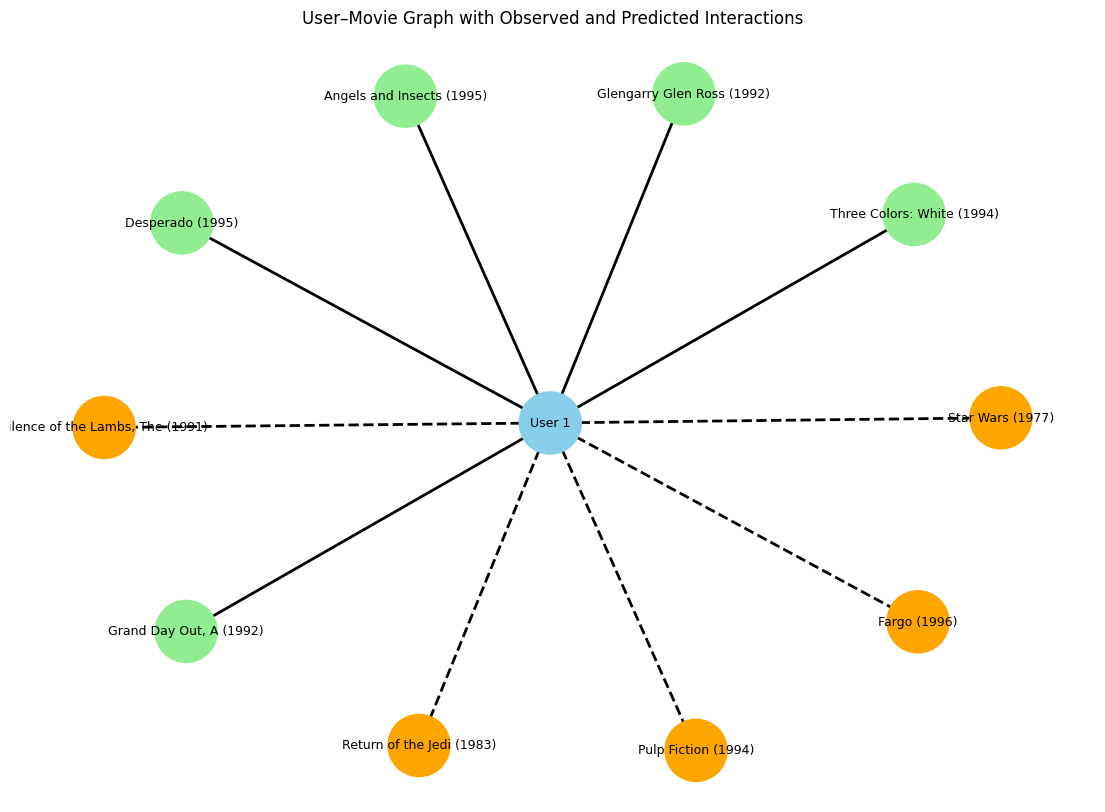

In [50]:
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42)

# Node coloring
node_colors = []
for node in G.nodes():
    if node == sample_user_node:
        node_colors.append("skyblue")        # user
    elif node in watched_movie_nodes:
        node_colors.append("lightgreen")     # watched
    else:
        node_colors.append("orange")         # recommended

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000)

# Solid edges: watched movies
solid_edges = [(u, v) for u, v, d in G.edges(data=True) if d["type"] == "watched"]
nx.draw_networkx_edges(G, pos, edgelist=solid_edges, width=2)

# Dashed edges: recommendations
dashed_edges = [(u, v) for u, v, d in G.edges(data=True) if d["type"] == "recommended"]
nx.draw_networkx_edges(G, pos, edgelist=dashed_edges, style="dashed", width=2)

# Labels
labels = nx.get_node_attributes(G, "label")
nx.draw_networkx_labels(G, pos, labels, font_size=9)

plt.title("User–Movie Graph with Observed and Predicted Interactions")
plt.axis("off")
plt.show()

# Multi-User Graph + Top-K Recommended Edges Only

In [70]:
import networkx as nx
import matplotlib.pyplot as plt

In [71]:
sample_users = [1, 5, 10]   # you can change these
TOP_K = 3                  # top-K recommendations per user

In [72]:
G = nx.Graph()

for user_id in sample_users:
    user_node = user_id_map[user_id]

    # add user node
    G.add_node(
        user_node,
        label=f"User {user_id}",
        node_type="user"
    )

    # watched movies (limit to avoid clutter)
    watched_movies = (
        ratings[ratings["userId"] == user_id]["movieId"]
        .head(3)
        .tolist()
    )

    for mid in watched_movies:
        movie_node = movie_id_map[mid]
        G.add_node(
            movie_node,
            label=movie_id_to_title.get(mid, "Unknown"),
            node_type="watched"
        )
        G.add_edge(user_node, movie_node, edge_type="watched")

    # top-K recommended movies (ONLY predicted edges)
    recommended = recommend_movies(user_id, top_k=TOP_K)
    recommended_movie_ids = [mid for mid, _, _ in recommended]

    for mid in recommended_movie_ids:
        movie_node = movie_id_map[mid]
        G.add_node(
            movie_node,
            label=movie_id_to_title.get(mid, "Unknown"),
            node_type="recommended"
        )
        G.add_edge(user_node, movie_node, edge_type="recommended")

In [73]:
pos = nx.spring_layout(G, seed=42, k=1.5)

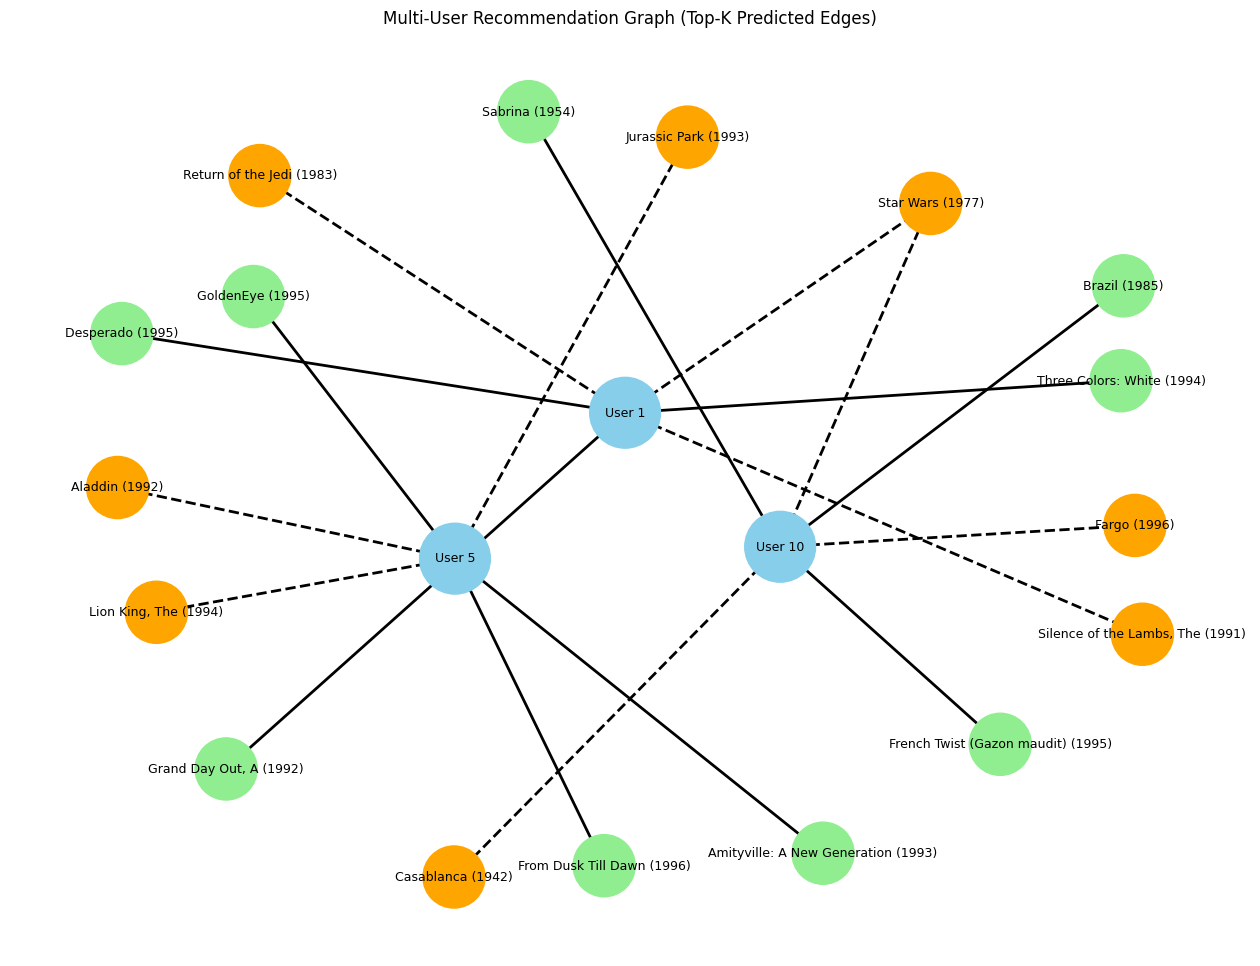

In [74]:
plt.figure(figsize=(16, 12))

node_colors = []
node_sizes = []

for _, attr in G.nodes(data=True):
    if attr["node_type"] == "user":
        node_colors.append("skyblue")
        node_sizes.append(2600)
    elif attr["node_type"] == "watched":
        node_colors.append("lightgreen")
        node_sizes.append(2000)
    else:
        node_colors.append("orange")
        node_sizes.append(2000)

# nodes
nx.draw_networkx_nodes(
    G,
    pos,
    node_color=node_colors,
    node_size=node_sizes
)

# watched edges (solid)
watched_edges = [
    (u, v) for u, v, d in G.edges(data=True)
    if d["edge_type"] == "watched"
]
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=watched_edges,
    width=2
)

# recommended edges (dashed, top-K only)
recommended_edges = [
    (u, v) for u, v, d in G.edges(data=True)
    if d["edge_type"] == "recommended"
]
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=recommended_edges,
    style="dashed",
    width=2
)

# labels
labels = nx.get_node_attributes(G, "label")
nx.draw_networkx_labels(G, pos, labels, font_size=9)

plt.title("Multi-User Recommendation Graph (Top-K Predicted Edges)")
plt.axis("off")
plt.show()

In [51]:
model.eval()
embeddings = model(data.x, data.edge_index).detach().cpu().numpy()

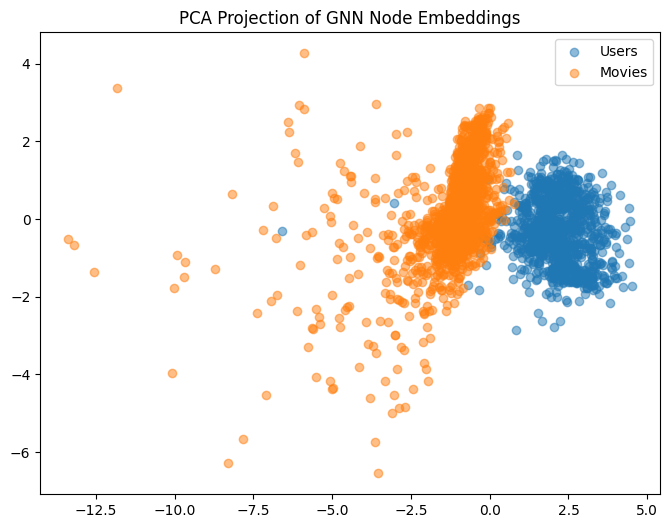

In [52]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(emb_2d[:num_users, 0], emb_2d[:num_users, 1], alpha=0.5, label="Users")
plt.scatter(emb_2d[num_users:, 0], emb_2d[num_users:, 1], alpha=0.5, label="Movies")
plt.legend()
plt.title("PCA Projection of GNN Node Embeddings")
plt.show()

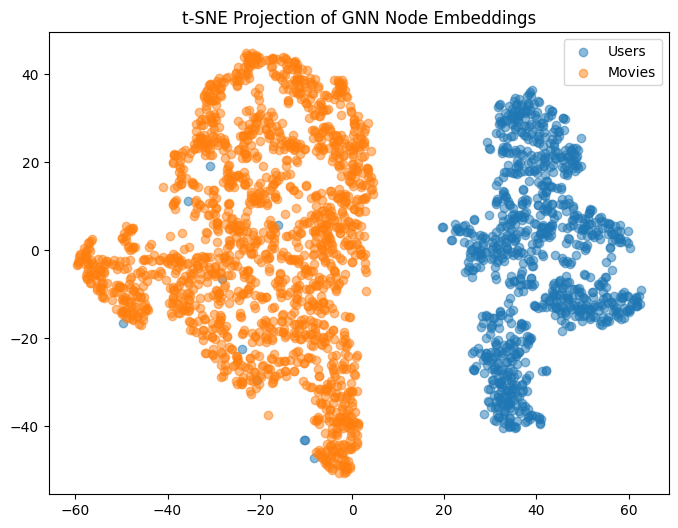

In [53]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(emb_tsne[:num_users, 0], emb_tsne[:num_users, 1], alpha=0.5, label="Users")
plt.scatter(emb_tsne[num_users:, 0], emb_tsne[num_users:, 1], alpha=0.5, label="Movies")
plt.legend()
plt.title("t-SNE Projection of GNN Node Embeddings")
plt.show()

# 🎬 GNN Movie Recommendation – Gradio App 

In [2]:
# !pip install gradio

In [76]:
import gradio as gr
import pandas as pd
import torch

In [77]:
def gradio_recommend(user_id, top_k):
    user_id = int(user_id)
    top_k = int(top_k)

    model.eval()
    embeddings = model(data.x, data.edge_index)

    user_node = user_id_map[user_id]

    # movies already watched
    watched = set(
        ratings[ratings["userId"] == user_id]["movieId"]
    )

    scores = []
    for movie_id in ratings["movieId"].unique():
        if movie_id in watched:
            continue

        movie_node = movie_id_map[movie_id]
        score = torch.dot(
            embeddings[user_node],
            embeddings[movie_node]
        ).item()

        title = movie_id_to_title.get(movie_id, "Unknown")
        scores.append((title, score))

    scores.sort(key=lambda x: x[1], reverse=True)
    top_movies = scores[:top_k]

    # format nicely
    output = ""
    for i, (title, score) in enumerate(top_movies, 1):
        output += f"{i}. {title}\n"

    return output

In [78]:
user_choices = sorted(ratings["userId"].unique().tolist())

In [79]:
with gr.Blocks(title="GNN Movie Recommendation System") as demo:
    gr.Markdown(
        """
        # 🎬 GNN-based Movie Recommendation System  
        Select a user and get **Top-K movie recommendations** generated using a **Graph Neural Network**.
        """
    )

    with gr.Row():
        user_input = gr.Dropdown(
            choices=user_choices,
            label="Select User ID",
            value=user_choices[0]
        )

        topk_input = gr.Slider(
            minimum=1,
            maximum=10,
            step=1,
            value=5,
            label="Top-K Recommendations"
        )

    recommend_btn = gr.Button("Get Recommendations 🎯")

    output_box = gr.Textbox(
        label="Recommended Movies",
        lines=10
    )

    recommend_btn.click(
        fn=gradio_recommend,
        inputs=[user_input, topk_input],
        outputs=output_box
    )

In [80]:
demo.launch()

* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://e8aaf50f1138448bfb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
